In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf


pd.set_option('display.max_columns', None)


In [32]:
import json

with open('../column_dtypes.json', 'r') as f:
    column_dtypes = json.load(f)

# Remove 'day' from column_dtypes and handle it separately with parse_dates
column_dtypes.pop('day', None)

column_dtypes

{'order_id': 'object',
 'billing_city': 'object',
 'customer_id': 'object',
 'product_id': 'object',
 'product_price': 'float64',
 'product_title': 'object',
 'product_type': 'object',
 'variant_id': 'object',
 'variant_sku': 'object',
 'variant_title': 'object',
 'api_client_title': 'object',
 'shipping_city': 'object',
 'market_name': 'object',
 'purchase_option': 'object',
 'cancelled': 'object',
 'cost_tracked': 'object',
 'financial_status': 'object',
 'order_name': 'object',
 'sale_kind': 'object',
 'billing_region': 'object',
 'billing_country': 'object',
 'customer_type': 'object',
 'customer_cohort_month': 'object',
 'customer_cohort_quarter': 'object',
 'referrer_url': 'object',
 'referrer_host': 'object',
 'referring_channel': 'object',
 'referring_platform': 'object',
 'marketing_event_target': 'object',
 'marketing_event_type': 'object',
 'adjustment': 'object',
 'total_sales': 'float64',
 'discounts': 'float64',
 'orders': 'int64',
 'customers': 'int64',
 'net_quantity': 

In [33]:
df = pd.read_csv('sales_clean.csv', dtype=column_dtypes, parse_dates=['day'])


In [34]:
df.select_dtypes(include=['float64', 'int64']).head()



,product_price,total_sales,discounts,orders,customers,net_quantity,ordered_item_quantity,gross_sales,net_sales,returns,shipping,taxes,units_per_transaction,average_order_value,unit_price,discount_percentage,discount_rate,discount_round
0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN


In [35]:
daily_sales = df.groupby('day').agg(net_sales_sum=('net_sales', 'sum'), count=('net_sales', 'count'), net_sales_avg=('net_sales', 'mean'), net_sales_std=('net_sales', 'std')).reset_index()


In [36]:
daily_sales


,day,net_sales_sum,count,net_sales_avg,net_sales_std
0,2018-09-23,0.0,1,0.0,NaN
1,2018-09-24,0.0,1,0.0,NaN
2,2018-09-25,0.0,1,0.0,NaN
3,2018-09-26,0.0,1,0.0,NaN
4,2018-09-27,0.0,1,0.0,NaN
...,...,...,...,...,...
2194,2024-09-25,0.0,1,0.0,NaN
2195,2024-09-26,340.2,3,113.4,98.207281
2196,2024-09-27,0.0,1,0.0,NaN
2197,2024-09-28,0.0,1,0.0,NaN


In [37]:
fig = px.line(daily_sales, x='day', y='net_sales_sum', title='Daily Sales Over Time')
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Net Sales'
)
fig.show()


In [38]:
import plotly.graph_objects as go
from statsmodels.tsa.stattools import acf

acf_values = acf(daily_sales['net_sales_sum'], nlags=365)

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, 367)), y=acf_values[1:], mode='lines+markers'))

fig.update_layout(
    title='Autocorrelation of Daily Sales (Up to One Year)',
    xaxis_title='Lag (Days)',
    yaxis_title='Autocorrelation'
)

fig.show()

In [39]:
fig = px.line(daily_sales, x='day', y='count', title='Daily Sales Over Time')
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Net Sales'
)
fig.show()


In [40]:
acf_values = acf(daily_sales['count'], nlags=365)

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, 367)), y=acf_values[1:], mode='lines+markers'))

# Add vertical lines for the first week, month, quarter, and year
fig.add_vline(x=7, line=dict(color='blue', dash='dash'), annotation_text='Week', annotation_position='top')
fig.add_vline(x=30, line=dict(color='green', dash='dash'), annotation_text='Month', annotation_position='top')
fig.add_vline(x=90, line=dict(color='red', dash='dash'), annotation_text='Quarter', annotation_position='top')
fig.add_vline(x=365, line=dict(color='purple', dash='dash'), annotation_text='Year', annotation_position='top')

fig.update_layout(
    title='Autocorrelation of Daily Sales (Up to One Year)',
    xaxis_title='Lag (Days)',
    yaxis_title='Autocorrelation'
)

fig.show()

In [41]:
window = 365

# Calculate the rolling mean and standard deviation for 'net_sales_sum' and 'count'
daily_sales['net_sales_sum_rolling_mean'] = daily_sales['net_sales_sum'].rolling(window=window).mean()
daily_sales['net_sales_sum_rolling_std'] = daily_sales['net_sales_sum'].rolling(window=30).std()
daily_sales['count_rolling_mean'] = daily_sales['count'].rolling(window=window).mean()
daily_sales['count_rolling_std'] = daily_sales['count'].rolling(window=window).std()

# Plot the rolling mean and standard deviation for 'net_sales_sum'
fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_sales['day'], y=daily_sales['net_sales_sum_rolling_mean'], mode='lines', name='Rolling Mean'))
fig.add_trace(go.Scatter(x=daily_sales['day'], y=daily_sales['net_sales_sum_rolling_std'], mode='lines', name='Rolling Std Dev'))

fig.update_layout(
    title='Rolling Mean and Standard Deviation of Net Sales Sum',
    xaxis_title='Date',
    yaxis_title='Net Sales Sum'
)

fig.show()

# Plot the rolling mean and standard deviation for 'count'
fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_sales['day'], y=daily_sales['count_rolling_mean'], mode='lines', name='Rolling Mean'))
fig.add_trace(go.Scatter(x=daily_sales['day'], y=daily_sales['count_rolling_std'], mode='lines', name='Rolling Std Dev'))

fig.update_layout(
    title='Rolling Mean and Standard Deviation of Sales Count',
    xaxis_title='Date',
    yaxis_title='Sales Count'
)

fig.show()


In [42]:
daily_sales


,day,net_sales_sum,count,net_sales_avg,net_sales_std,net_sales_sum_rolling_mean,net_sales_sum_rolling_std,count_rolling_mean,count_rolling_std
0,2018-09-23,0.0,1,0.0,NaN,NaN,NaN,NaN,NaN
1,2018-09-24,0.0,1,0.0,NaN,NaN,NaN,NaN,NaN
2,2018-09-25,0.0,1,0.0,NaN,NaN,NaN,NaN,NaN
3,2018-09-26,0.0,1,0.0,NaN,NaN,NaN,NaN,NaN
4,2018-09-27,0.0,1,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2194,2024-09-25,0.0,1,0.0,NaN,543.615479,327.395556,5.134247,5.132963
2195,2024-09-26,340.2,3,113.4,98.207281,544.547534,322.326617,5.139726,5.129604
2196,2024-09-27,0.0,1,0.0,NaN,544.081507,322.326617,5.136986,5.131553
2197,2024-09-28,0.0,1,0.0,NaN,542.585616,322.326617,5.115068,5.132092


In [43]:
daily_sales['net_sales_sum_detrend'] = (daily_sales['net_sales_sum'] - daily_sales['net_sales_sum_rolling_mean']) / daily_sales['net_sales_sum_rolling_std']
daily_sales['count_detrend'] = (daily_sales['count'] - daily_sales['count_rolling_mean']) / daily_sales['count_rolling_std']

# Plot the detrended net sales sum
fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_sales['day'], y=daily_sales['net_sales_sum_detrend'], mode='lines', name='Detrended Net Sales Sum'))

fig.update_layout(
    title='Detrended Net Sales Sum',
    xaxis_title='Date',
    yaxis_title='Detrended Net Sales Sum'
)

fig.show()

# Plot the detrended sales count
fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_sales['day'], y=daily_sales['count_detrend'], mode='lines', name='Detrended Sales Count'))

fig.update_layout(
    title='Detrended Sales Count',
    xaxis_title='Date',
    yaxis_title='Detrended Sales Count'
)

fig.show()



In [44]:
daily_sales[daily_sales['net_sales_sum'] < 0]


,day,net_sales_sum,count,net_sales_avg,net_sales_std,net_sales_sum_rolling_mean,net_sales_sum_rolling_std,count_rolling_mean,count_rolling_std,net_sales_sum_detrend,count_detrend
538,2020-03-14,-78.00,1,-78.000000,NaN,10.846575,58.385845,1.024658,0.187362,-1.521714,-0.131604
620,2020-06-04,-25.00,1,-25.000000,NaN,43.435068,123.577835,1.254795,1.128190,-0.553781,-0.225844
655,2020-07-09,-41.00,6,-6.833333,69.054809,63.977534,241.910051,1.580822,1.716809,-0.433953,2.574065
703,2020-08-26,-44.10,1,-44.100000,NaN,67.888712,106.411227,1.761644,1.856281,-1.052414,-0.410306
1276,2022-03-22,-15.90,1,-15.900000,NaN,647.668658,200.401884,12.323288,12.176794,-3.311190,-0.929907
1546,2022-12-17,-185.50,1,-185.500000,NaN,408.089562,612.786963,4.156164,4.786686,-0.968672,-0.659363
1550,2022-12-21,-5.00,2,-2.500000,3.535534,423.447753,1294.057510,4.057534,4.658029,-0.331089,-0.441718
1557,2022-12-28,-126.75,1,-126.750000,NaN,419.419918,1285.716045,3.947945,4.589169,-0.424798,-0.642370
1618,2023-02-27,-12.00,1,-12.000000,NaN,358.617890,123.793075,2.854795,2.855159,-2.993850,-0.649629
1799,2023-08-27,-170.10,1,-170.100000,NaN,255.016822,157.115309,2.589041,2.433938,-2.705763,-0.652868


In [45]:
acf_values = acf(daily_sales['count_detrend'].dropna(), nlags=365)

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, 367)), y=acf_values[1:], mode='lines+markers'))

# Add vertical lines for the first week, month, quarter, and year
fig.add_vline(x=6, line=dict(color='blue', dash='dash'), annotation_text='Week', annotation_position='top')
fig.add_vline(x=29, line=dict(color='green', dash='dash'), annotation_text='Month', annotation_position='top')
fig.add_vline(x=89, line=dict(color='red', dash='dash'), annotation_text='Quarter', annotation_position='top')
fig.add_vline(x=364, line=dict(color='purple', dash='dash'), annotation_text='Year', annotation_position='top')

fig.update_layout(
    title='Autocorrelation of Daily Sales (Up to One Year)',
    xaxis_title='Lag (Days)',
    yaxis_title='Autocorrelation'
)

fig.show()

In [46]:
daily_sales['year'] = daily_sales['day'].dt.year
daily_sales['month'] = daily_sales['day'].dt.month
daily_sales['d'] = daily_sales['day'].dt.day


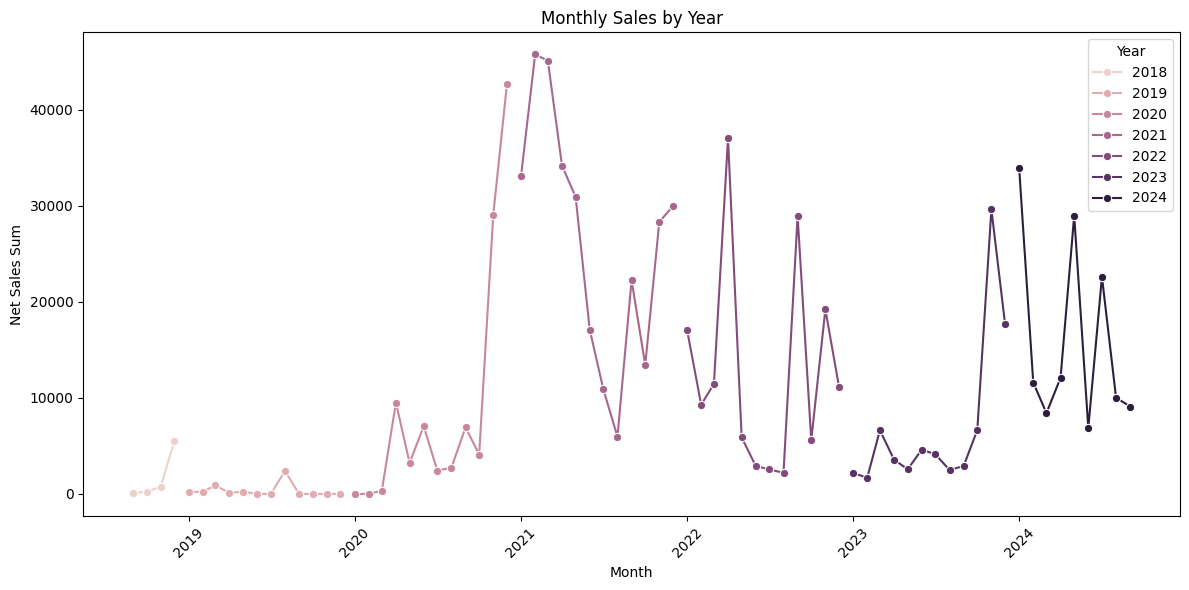

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

monthly_sales = daily_sales.groupby(['year', 'month'])['net_sales_sum'].sum().reset_index()

# Convert year and month to datetime for proper ordering
monthly_sales['date'] = pd.to_datetime(monthly_sales[['year', 'month']].assign(day=1))

# Sort the dataframe by date
monthly_sales = monthly_sales.sort_values('date')

# Create a line graph of monthly sales using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='date', y='net_sales_sum', hue='year', marker='o')

# Update layout
plt.title('Monthly Sales by Year')
plt.xlabel('Month')
plt.ylabel('Net Sales Sum')
plt.legend(title='Year')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()




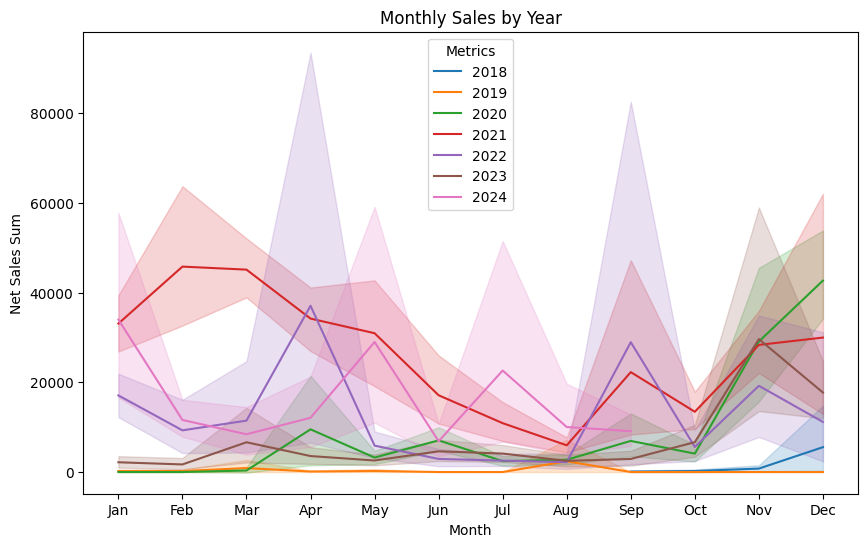

In [48]:
# Loop to create a plot for each year, with the metrics as lines
plt.figure(figsize=(10, 6))
for year in daily_sales.year.unique():
    sns.lineplot(data=daily_sales[daily_sales['year'] == year], x='month', y='net_sales_sum', label=year, estimator='sum')
plt.title(f'Monthly Sales by Year')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Net Sales Sum')
plt.xlabel('Month')
plt.legend(title="Metrics")
plt.show()

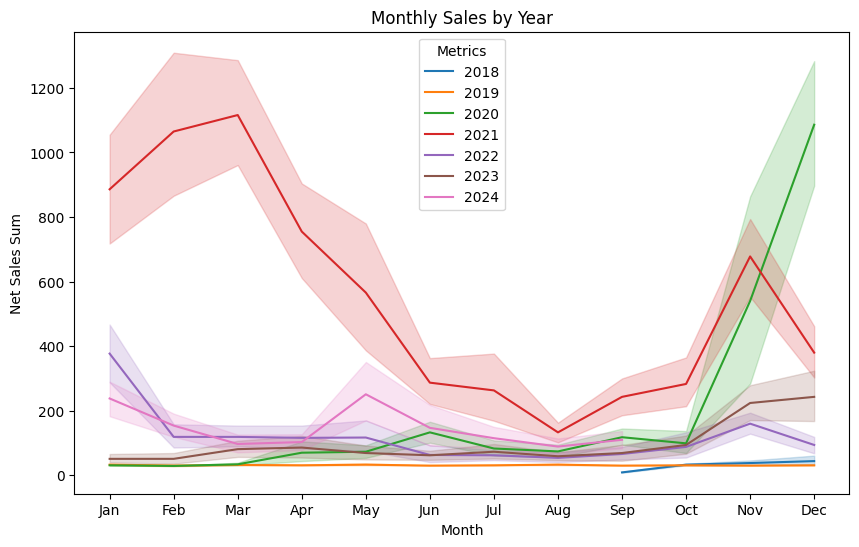

In [49]:
# Loop to create a plot for each year, with the metrics as lines
plt.figure(figsize=(10, 6))
for year in daily_sales.year.unique():
    sns.lineplot(data=daily_sales[daily_sales['year'] == year], x='month', y='count', label=year, estimator='sum')
plt.title(f'Monthly Sales by Year')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Net Sales Sum')
plt.xlabel('Month')
plt.legend(title="Metrics")
plt.show()

In [50]:
ref_ds = df.groupby(['day', 'referring_channel']).agg(net_sales_sum=('net_sales', 'sum'), count=('net_sales', 'count'), net_sales_avg=('net_sales', 'mean'), net_sales_std=('net_sales', 'std')).reset_index()

ref_ds['year'] = ref_ds['day'].dt.year
ref_ds['month'] = ref_ds['day'].dt.month
ref_ds['d'] = ref_ds['day'].dt.day

ref_ds = ref_ds.groupby(['year', 'month', 'referring_channel']).agg(net_sales_sum=('net_sales_sum', 'sum'), count=('count', 'sum')).reset_index()




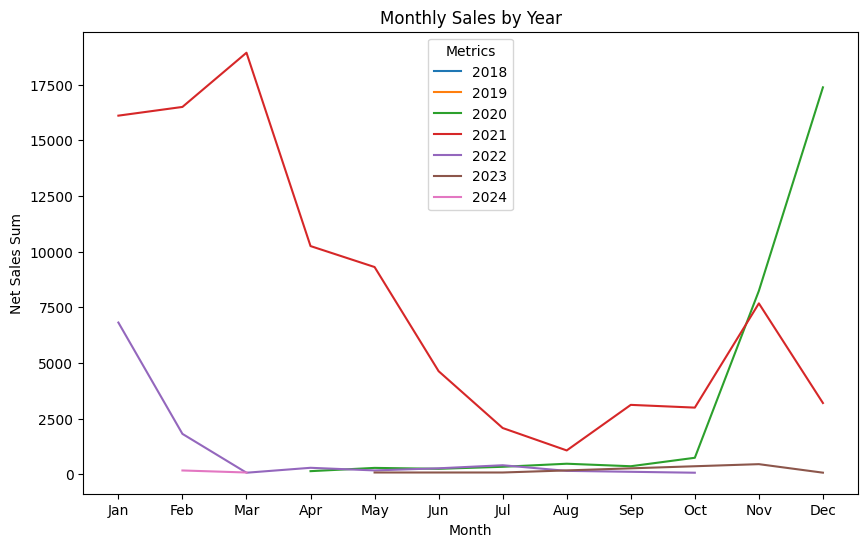

In [51]:
plt.figure(figsize=(10, 6))
for year in ref_ds.year.unique():
    sns.lineplot(data=ref_ds[(ref_ds['year'] == year) & (ref_ds['referring_channel'] == 'facebook')], x='month', y='net_sales_sum', label=year, estimator='sum', errorbar=None)
plt.title(f'Monthly Sales by Year')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Net Sales Sum')
plt.xlabel('Month')
plt.legend(title="Metrics")
plt.show()

In [52]:
df['detrended_net_sales'] = sm.tsa.seasonal_decompose(df['net_sales'], model='additive', period=12).resid

fig = px.line(df, x='day', y='detrended_net_sales', title='Detrended Net Sales Over Time',
             labels={'detrended_net_sales': 'Detrended Net Sales', 'day': 'Time'},
             hover_data={'day': '|%B %Y'})

fig.update_traces(mode='lines', line=dict(width=2))



In [54]:
# Calculate the discounted price
df['price_discounted'] = df['product_price'] * (1 - df['discount_rate'])

# Ensure the discounted price is not negative
df['price_discounted'] = df['price_discounted'].clip(lower=0)

# Display the first few rows to verify the new column
print(df[['product_price', 'discount_rate', 'price_discounted']].head())


   product_price  discount_rate  price_discounted
0            0.0            NaN               NaN
1            0.0            NaN               NaN
2            0.0            NaN               NaN
3            0.0            NaN               NaN
4            0.0            NaN               NaN


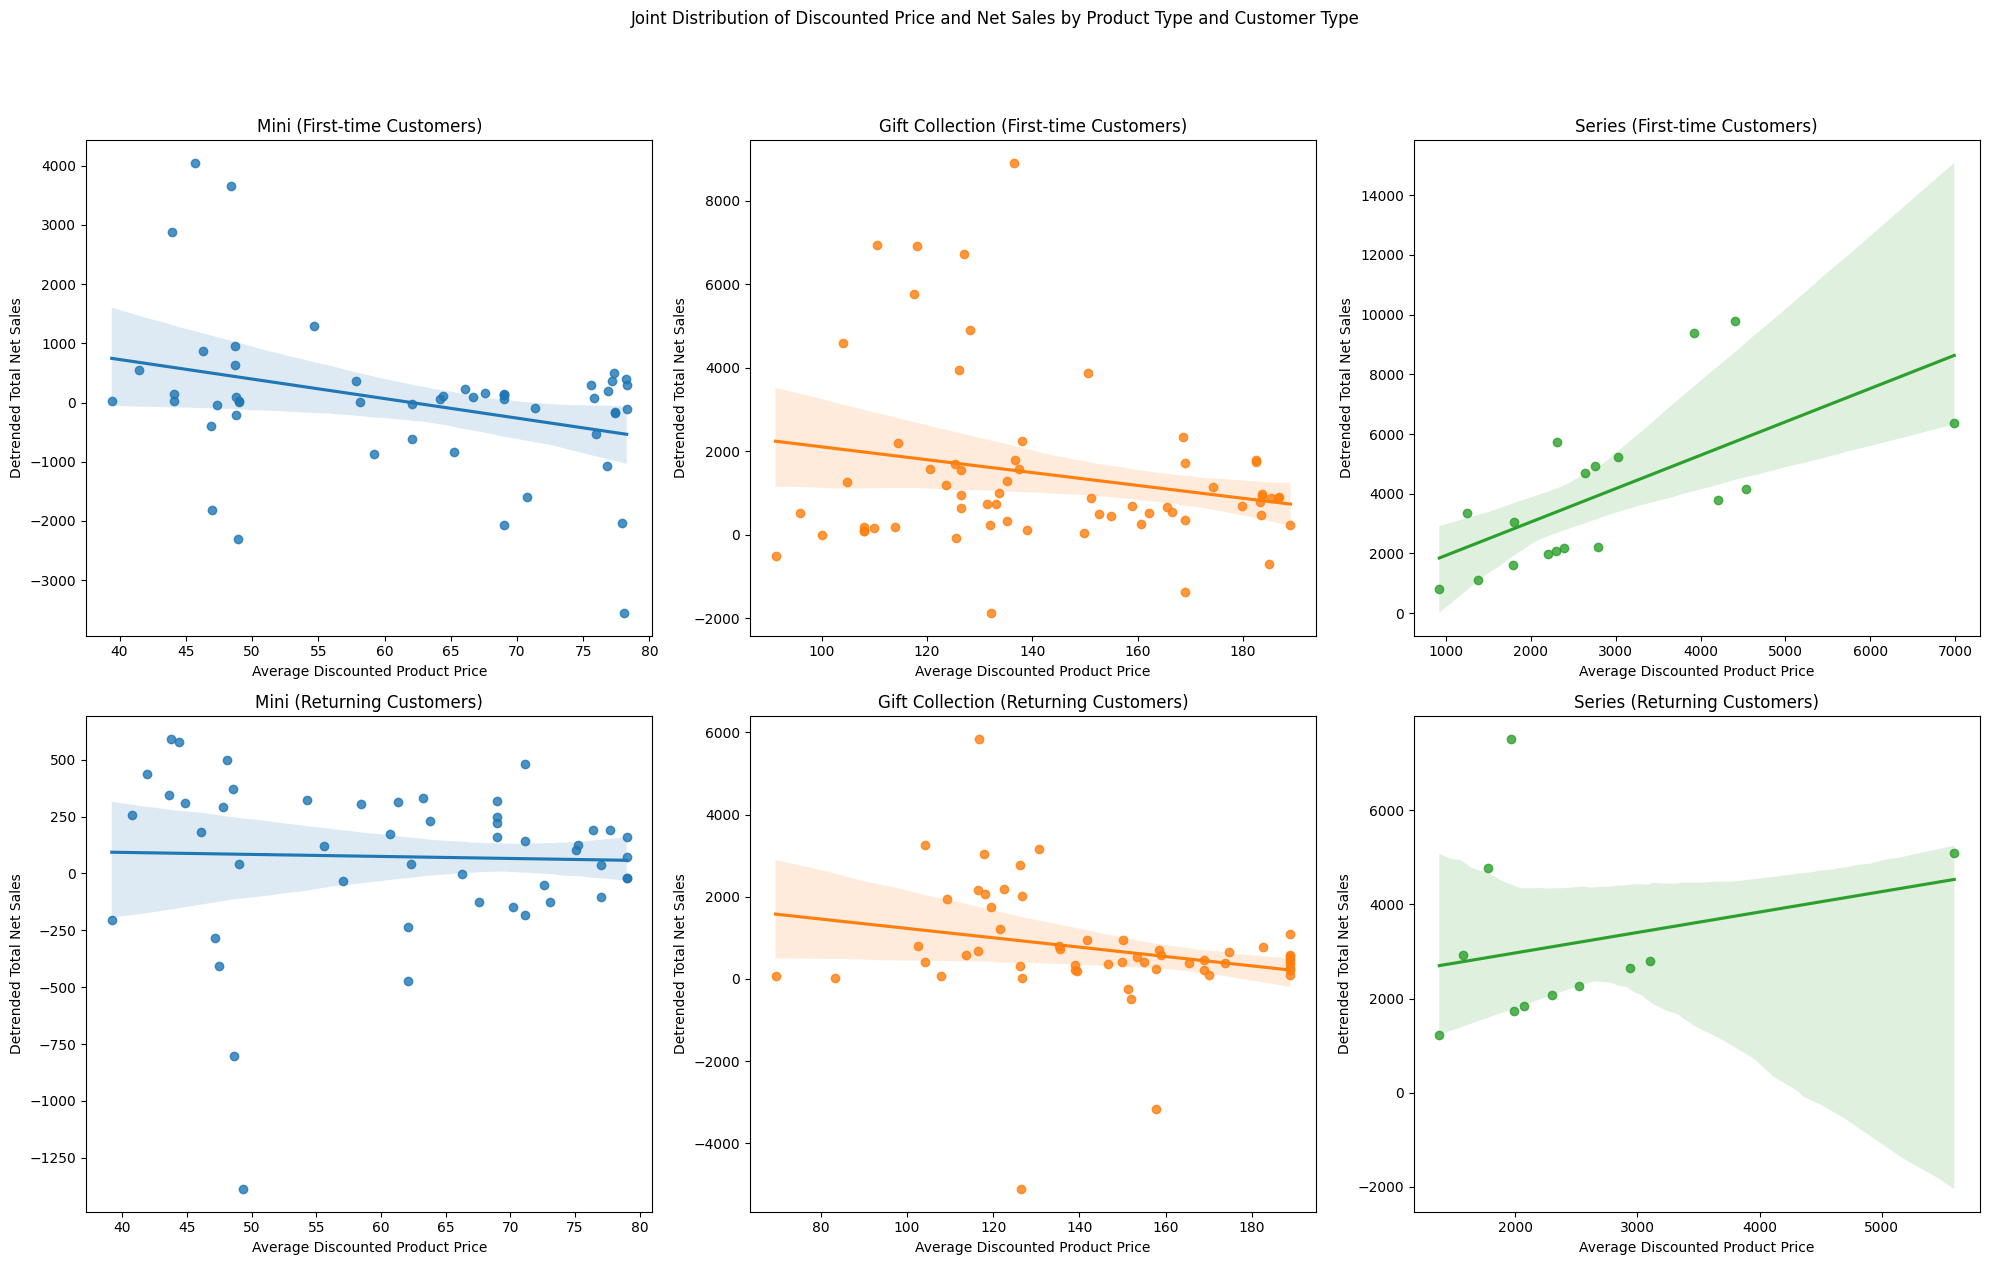

In [55]:
product_types = ['Mini', 'Gift Collection', 'Series']
customer_types = ['First-time', 'Returning']

filtered_df = df[df.product_type.isin(product_types) & ~((df.product_type == 'Gift Collection') & (df.product_price > 500))]

# Create figure
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle("Joint Distribution of Discounted Price and Net Sales by Product Type and Customer Type", y=1.05)

for j, customer_type in enumerate(customer_types):
    # Filter data for current customer type
    customer_df = filtered_df[filtered_df.customer_type == customer_type]
    
    # Group by month and product type, calculate mean discounted price and sum of net sales
    monthly_data = customer_df.groupby([customer_df['day'].dt.to_period('M'), 'product_type']).agg({
        'price_discounted': 'mean',
        'product_price': 'mean',
        'net_sales': 'sum',
        'detrended_net_sales': 'sum'
    }).reset_index()

    # Convert period to datetime for plotting
    monthly_data['day'] = monthly_data['day'].dt.to_timestamp()

    for i, product_type in enumerate(product_types):
        data = monthly_data[(monthly_data['product_type'] == product_type)
                            ]
        
        # Create regplot for each product type and customer type
        sns.regplot(
            data=data,
            x="price_discounted",
            y="detrended_net_sales",
            scatter=True,
            fit_reg=True,
            color=sns.color_palette()[i],
            ax=axes[j, i]
        )
        
        # Customize each subplot
        axes[j, i].set_title(f"{product_type} ({customer_type} Customers)")
        axes[j, i].set_xlabel("Average Discounted Product Price")
        axes[j, i].set_ylabel("Detrended Total Net Sales")

# Adjust layout
plt.tight_layout()
plt.show()

Pearson's correlation between detrended monthly net sales and average discounted price:
      Product Type Customer Type  Correlation   P-value
0             Mini    First-time    -0.338818  0.015013
1             Mini     Returning    -0.032624  0.823901
2  Gift Collection    First-time    -0.210815  0.097220
3  Gift Collection     Returning    -0.236117  0.082652
4           Series    First-time     0.641786  0.004089
5           Series     Returning     0.269718  0.422504


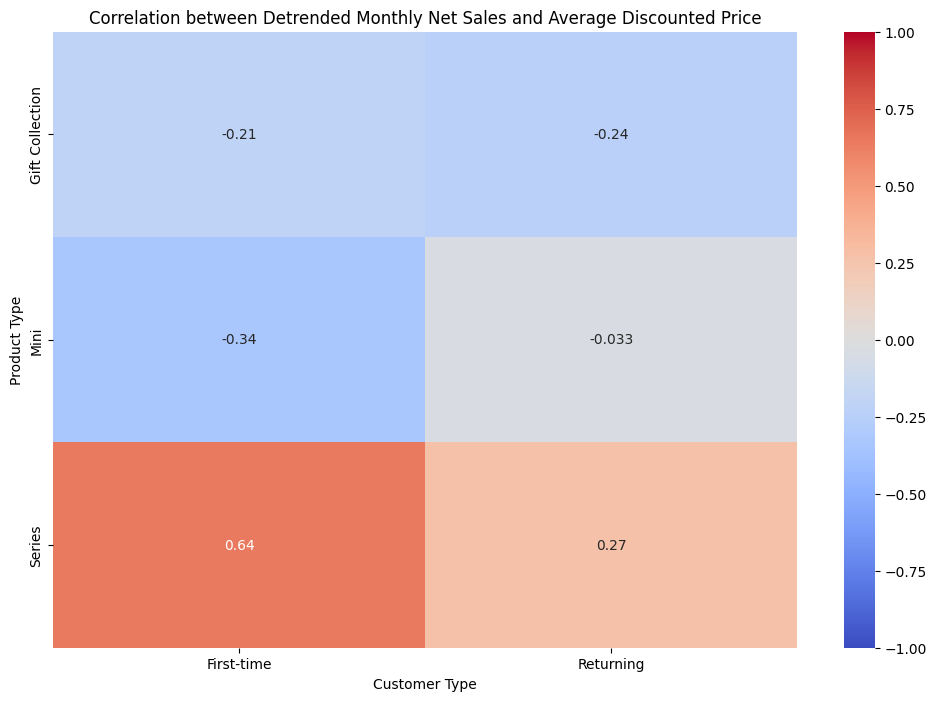

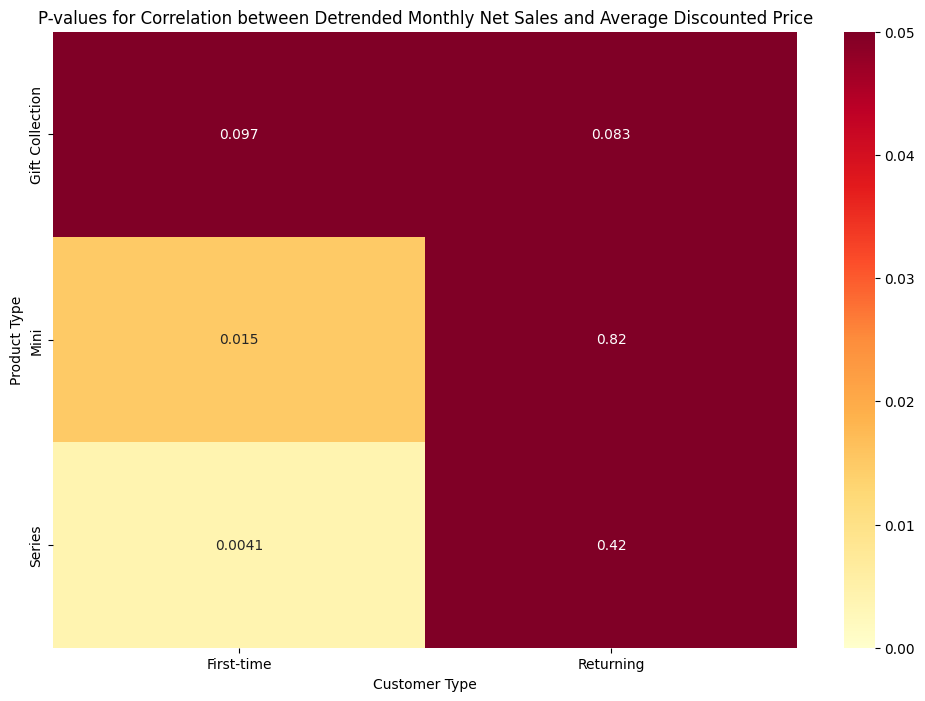

In [56]:
from scipy import stats

# Aggregate data by month, product type, and customer type
monthly_data = filtered_df.groupby([filtered_df['day'].dt.to_period('M'), 'product_type', 'customer_type']).agg({
    'detrended_net_sales': 'sum',
    'price_discounted': 'mean'
}).reset_index()

# Calculate Pearson's correlation and p-value between net sales and product price for each product type and customer type
correlations = []

for product_type in product_types:
    for customer_type in customer_types:
        # Filter data for current product type and customer type
        subset = monthly_data[(monthly_data['product_type'] == product_type) & 
                              (monthly_data['customer_type'] == customer_type)]
        
        # Calculate correlation and p-value
        correlation, p_value = stats.pearsonr(subset['detrended_net_sales'], subset['price_discounted'])
        
        correlations.append({
            'Product Type': product_type,
            'Customer Type': customer_type,
            'Correlation': correlation,
            'P-value': p_value
        })

# Create a DataFrame from the results
correlation_df = pd.DataFrame(correlations)

# Display the results
print("Pearson's correlation between detrended monthly net sales and average discounted price:")
print(correlation_df)

# Create a heatmap of the correlations
plt.figure(figsize=(12, 8))
correlation_pivot = correlation_df.pivot(index='Product Type', columns='Customer Type', values='Correlation')
sns.heatmap(correlation_pivot, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Correlation between Detrended Monthly Net Sales and Average Discounted Price")
plt.show()
# Create a heatmap of the p-values
plt.figure(figsize=(12, 8))
p_value_pivot = correlation_df.pivot(index='Product Type', columns='Customer Type', values='P-value')
sns.heatmap(p_value_pivot, annot=True, cmap='YlOrRd', vmin=0, vmax=0.05)
plt.title("P-values for Correlation between Detrended Monthly Net Sales and Average Discounted Price")
plt.show()


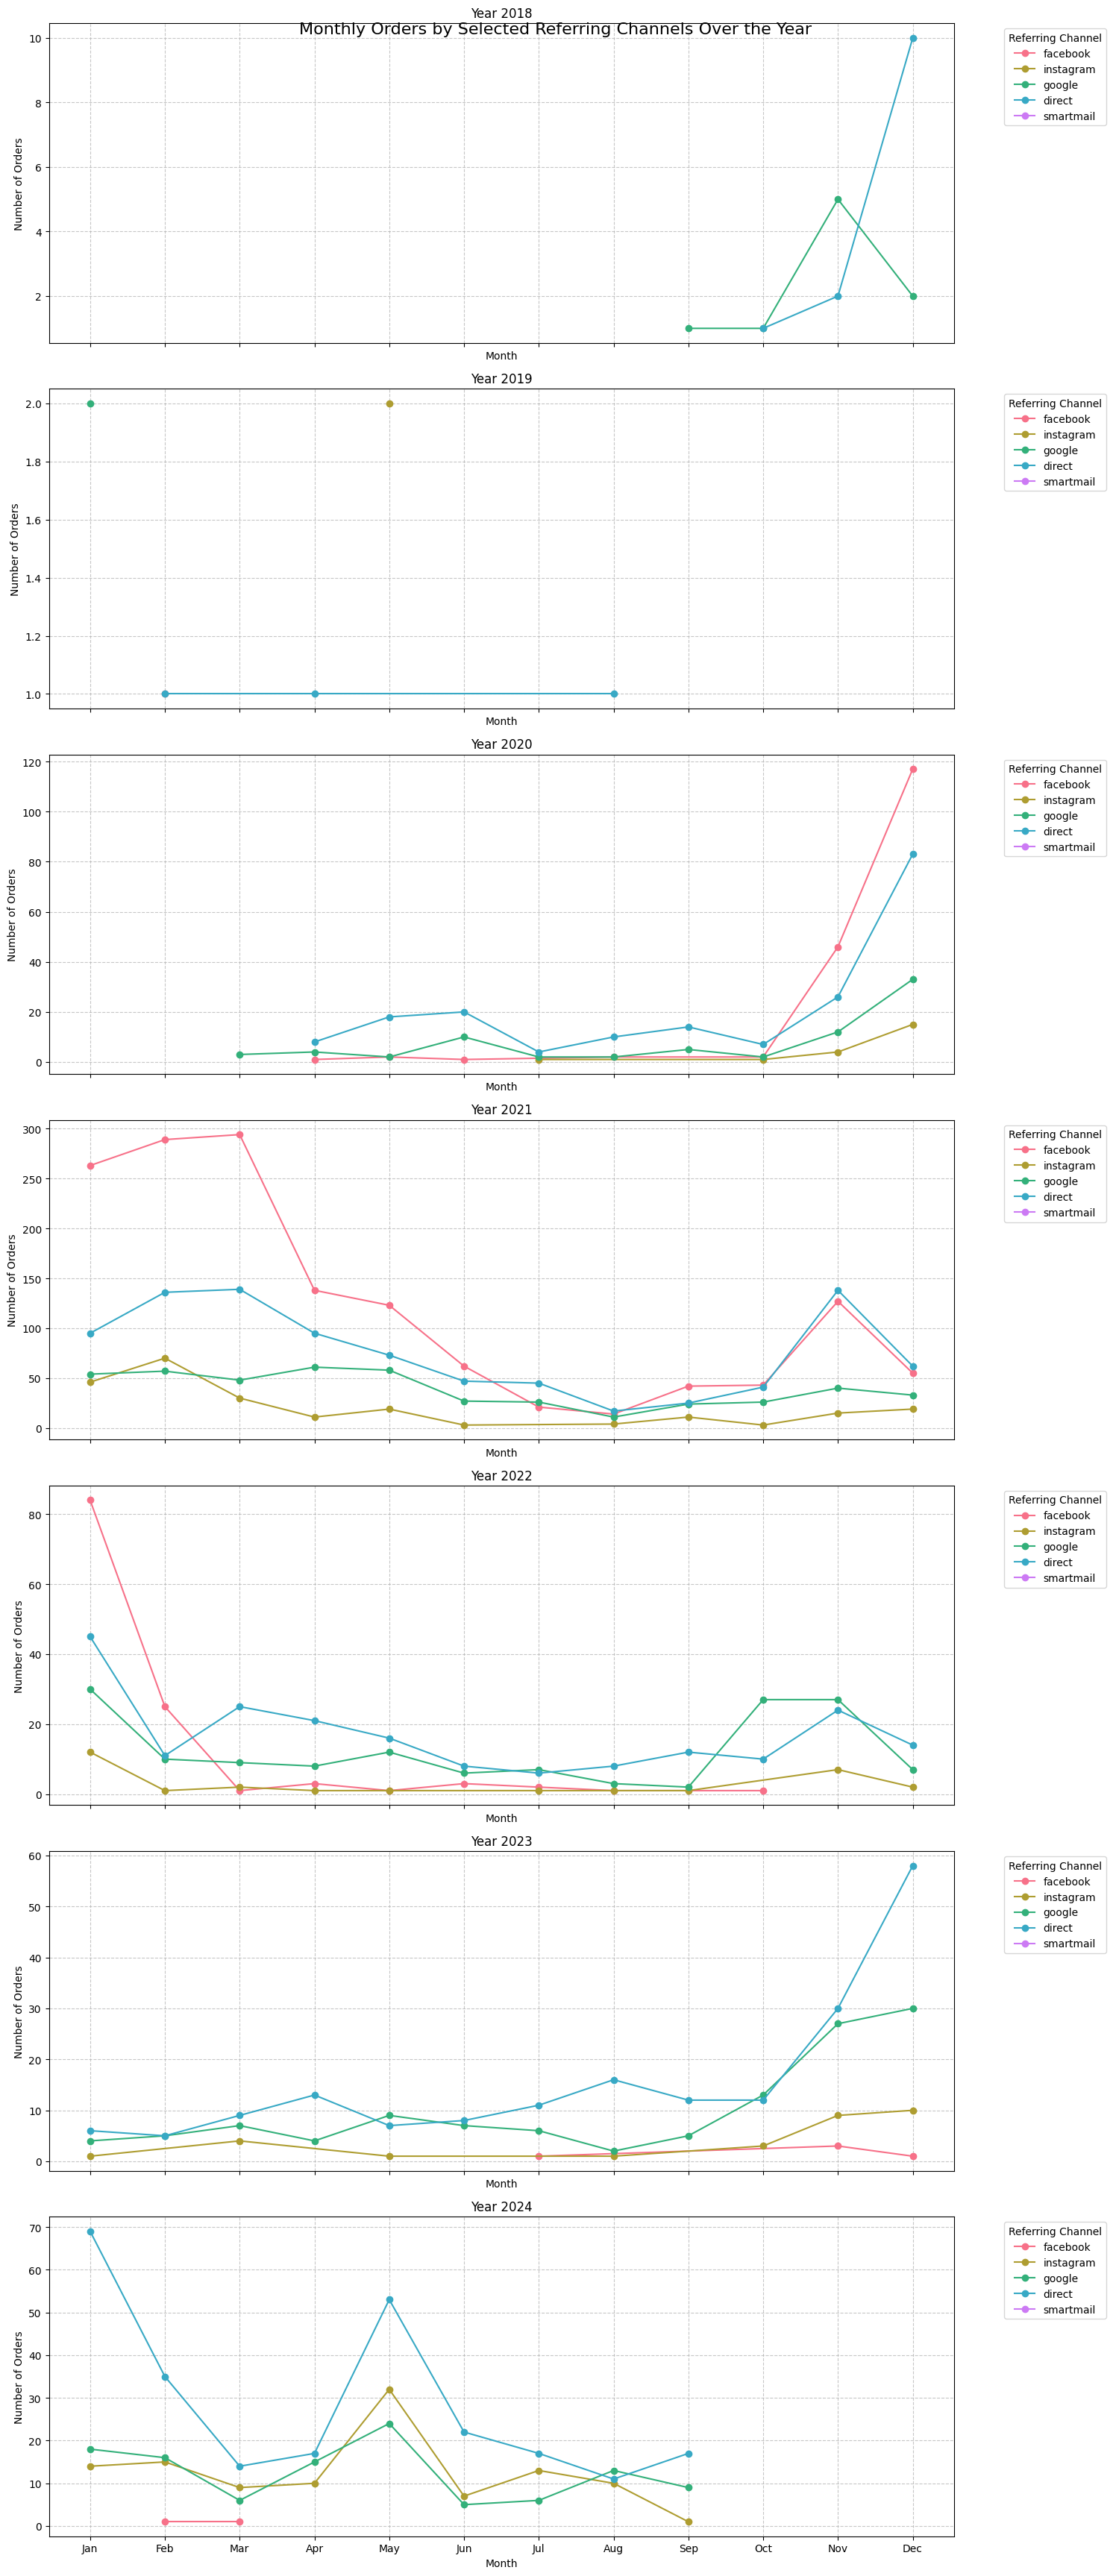

In [58]:
# Group data by month and referring_channel, count orders
orders_by_channel = filtered_df.groupby([filtered_df['day'].dt.to_period('M'), 'referring_channel'])['orders'].sum().reset_index()

# Convert month back to datetime for easier plotting
orders_by_channel['month'] = orders_by_channel['day'].dt.to_timestamp()

# Add year and month number columns
orders_by_channel['year'] = orders_by_channel['month'].dt.year
orders_by_channel['month_num'] = orders_by_channel['month'].dt.month

# Get unique years and select specific referring channels
years = sorted(orders_by_channel['year'].unique())
channels = ['facebook', 'instagram', 'google', 'direct', 'smartmail']

# Create a color palette for the selected channels
color_palette = sns.color_palette("husl", n_colors=len(channels))

# Create subplots
fig, axes = plt.subplots(len(years), 1, figsize=(15, 5*len(years)), sharex=True)
fig.suptitle('Monthly Orders by Selected Referring Channels Over the Year', fontsize=16)

for i, year in enumerate(years):
    ax = axes[i] if len(years) > 1 else axes
    year_data = orders_by_channel[orders_by_channel['year'] == year]
    
    for j, channel in enumerate(channels):
        channel_data = year_data[year_data['referring_channel'] == channel]
        ax.plot(channel_data['month_num'], channel_data['orders'], 
                label=channel, color=color_palette[j], marker='o')
    
    ax.set_title(f'Year {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Orders')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.legend(title='Referring Channel', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

